# Практическое занятие №2 - локализация объектов на изображениях

1. Разметка данных с помощью виджета QSL для Jupyter (https://github.com/faustomorales/qsl)
2. Расширение выборки за счет модификации размеченных данных (процедура аугоментация).
3. Знакомство с архитектурой нейронных сетей для локализации объектов на изображении.
4. Обучение нейронных сетей для детекции объектов.
5. Проверка обученной модели для обработки видео потока.
6. Трекинг объектов.
7. Распознавание сцен с помощью простого классификатора.
9. Разработка простой системы управления по данным с видео-камеры.

schema1.svg

In [ ]:
#@title
%%html
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/video_1.mp4" type="video/mp4"/>
</video>
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/video_3.mp4" type="video/mp4"/>
</video>
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_3/video_4.mp4" type="video/mp4"/>
</video>
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_4/video_4.mp4" type="video/mp4"/>
</video>

# Разметка кадров для обучающей выборки

In [1]:
!pip install -U -q qsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00


In [2]:
# Активация расширенных виджетов в Colab (можно закомментировать при запуске в Jupyter)
import google.colab
google.colab.output.enable_custom_widget_manager()

In [3]:
import qsl

In [4]:
%%writefile images.csv
target
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_001.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_002.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_003.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_005.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_006.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_007.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_008.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_009.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_010.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_3/image_011.jpg

Writing images.csv


In [5]:
import pandas

image_file = pandas.read_csv('images.csv')

In [6]:
labeler = qsl.MediaLabeler(
    items=image_file.to_dict(orient='records'),
    config={
        "regions": [
            {"name": "Object", "multiple": True, "options": [{"name": "bottle"}, {"name": "bug"}]}
        ]
    })
labeler.mode = "dark"
labeler

MediaLabeler(buttons={'prev': False, 'next': True, 'save': True, 'config': True, 'delete': False, 'ignore': Tr…

In [15]:
import json

with open('result.json', 'w') as file:
    file.write(json.dumps(labeler.items, sort_keys=True, indent=4))

In [ ]:
labels = None
with open('result.json', 'r') as file:
    labels = file.read()
    print(labels)

In [82]:
!wget -O object_masks.json 'https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/object_masks.json'

--2023-02-20 11:32:46--  https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/object_masks.json
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ant-nik/neural_network_course/main/practice_2_data/object_masks.json [following]
--2023-02-20 11:32:46--  https://raw.githubusercontent.com/ant-nik/neural_network_course/main/practice_2_data/object_masks.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119077 (116K) [text/plain]
Saving to: ‘object_masks.json’

object_masks.json   100%[===================>] 116.29K  --.-KB/s    in 0.02s   

2023-02-20 11:32:46 (5.37 MB/s) - ‘objec

In [83]:
labels = None
with open('object_masks.json', 'r') as file:
    labels = file.read()
label_data = json.loads(labels)

In [84]:
labeler = qsl.MediaLabeler(
    items=label_data,
    
    #image_file.to_dict(orient='records'),
    config={
        "regions": [
            {"name": "Type", "multiple": True, "options": [{"name": "bottle"}, {"name": "bag"}]}
        ]
    })
labeler.labels
labeler.mode = "dark"
labeler

MediaLabeler(buttons={'prev': False, 'next': True, 'save': True, 'config': True, 'delete': True, 'ignore': Fal…

In [13]:
class Struct(object):

    def __init__(self, data):
        for name, value in data.items():
            setattr(self, name, self._wrap(value))

    def _wrap(self, value):
        if isinstance(value, (tuple, list, set, frozenset)): 
            return type(value)([self._wrap(v) for v in value])
        else:
            return Struct(value) if isinstance(value, dict) else value

    def __str__(self):
        result = '{'
        first = True
        for field in self.__dict__.keys():
            if not first:
                result += ', '
            else:
                first = False
            result += f'{field}: {str(self.__dict__[field])}'
        return result + '}'

    def __repr__(self):
        return str(self)

In [85]:
labels = [Struct(label) for label in label_data]

# Расширение обучающей выборки 

На практике не всегда удается собрать достаточно размеченного материала для качественного обучения нейронной сети. Кроме того, использование большого массива изображений без должного анализа состава приводит к разбалансировке процесса обучения. Например, в общем потоке изображений какие-либо классы объектов могут быть представлены незначительным числом примеров и по этой причине их распознавание во время обучения будет иметь малую значимость на фоне остальных классов. В этой связи все современные модели при обучении предполагают в определенной степени крапотливое конструирование синтетического набора данных на основе исходных изображений. Подробный обзор стратегий расширения выборки за счет изменения исходных изображений представлен в статье "A Comprehensive Survey of Image Augmentation Techniques for Deep Learning" (https://arxiv.org/abs/2205.01491).

Далее будем использовать следующий способ расширения выборки изображений.
1. Извлечение изображений интересующих нас объектов из исходных данных.
2. Создание набора фоновых изображений для размещения объектов.
3. Определение набора трасформаций изображений объектов и фона, включая масштабирование, отражения, повороты, обрезку, изменение цвета/насыщенности, наложение шума.
4. Размещение объектов на фоне в случайных местах.

В настоящее время нет необходимости реализовывать с нуля все шаги синтеза изображений, т.к. существуюет большой набор готовых решений. Наиболее популярными решениями служат следующие пакеты Python.

1. https://pytorch.org/vision/stable/transforms.html
2. https://www.tensorflow.org/tutorials/images/data_augmentation?hl=en
3. https://augmentor.readthedocs.io/en/master/
4. https://github.com/albumentations-team/albumentations

Важным вопросом при расширении выборки является выбор параметров. Он может быть выполнен как эмпирически, так и путем оптимизации. В последнем случае используют либо целевую модель, либо её малый эквивалент с целью вариации параметров и оценки качества обучения. Логичным итогом такого рода работы становятся так называемые "системы автоаугоментации", в которые встраивается универсальная внутренняя модель и алгоритм оптимизации для подбора параметров трансформаций. Они могут использоваться для расширения новых наборов данных без дополнительных усилий со стороны разработчика (но ценой значительного расхода вычислений, т.к. необходимо многократно проводить процесс обучения моделей). Более подробно об основной идее такого автоматического подхода можно почитать в статье сотрудников компании Google (https://arxiv.org/abs/1805.09501), а также изучить похожую реализацию в пакете deepaugment - https://github.com/barisozmen/deepaugment (к сожалению, пакет больше не поддерживается, последнее обновление исходного кода было в 2019 году).
Далее будем использовать более простой "эмпирический способ".



In [10]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 4.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [139]:
import requests
import numpy
import cv2
from collections import namedtuple
import typing


class MaskedObjectImage:

    def __init__(self, image, mask, label):
        self.orig_image = image
        self.mask = mask
        self.label = label

    @property
    def image(self):
        pass


RawObject = namedtuple('RawObject', ['image_url', 'mask_polygon', 'label'])


class MaskedObjectsDataset:

    def __init__(self, metadata: typing.List[Struct]):
        self.metadata = metadata
        self.objects_meta = [
            RawObject(image_url=image.target,
                      label=obj.labels.Type[0],
                      mask_polygon=pandas.DataFrame.from_records(
                          [vars(point) for point in obj.points]))
            for image in self.metadata
            for obj in image.labels.polygons
            ]
        self.basic_images = {}
        self.objects = {}

    def __len__(self) -> int:
        return len(self.objects_meta)

    def __getitem__(self, i) -> MaskedObjectImage:
        if i not in self.objects:
            self.__create_object(i)

        return self.objects[i]

    def __create_object(self, i):
        object_meta = self.objects_meta[i]
        image = None
        if not object_meta.image_url in self.basic_images:
            responce = requests.get(object_meta.image_url)
            if not responce.status_code == 200:
                raise Exception("Error, cant get image {}: {}".format(
                    object_meta.image_url, responce.status_code))
            raw_bytes = numpy.frombuffer(responce.content, dtype=numpy.uint8)
            self.basic_images[object_meta.image_url] = cv2.imdecode(
                raw_bytes, cv2.IMREAD_COLOR)

        basic_image = self.basic_images[object_meta.image_url]
        min_x = int(object_meta.mask_polygon['x'].min()*basic_image.shape[1])
        min_y = int(object_meta.mask_polygon['y'].min()*basic_image.shape[0])
        max_x = int(object_meta.mask_polygon['x'].max()*basic_image.shape[1])
        max_y = int(object_meta.mask_polygon['y'].max()*basic_image.shape[0])
        image = basic_image[min_y:max_y, min_x:max_x, :]
        mask = numpy.zeros(image.shape, dtype=numpy.uint8)
        object_meta.mask_polygon['nx'] = (
            object_meta.mask_polygon['x']*basic_image.shape[1]).map(int) - min_x
        object_meta.mask_polygon['ny'] = (
            object_meta.mask_polygon['y']*basic_image.shape[0]).map(int) - min_y
        cv2.fillPoly(mask, numpy.expand_dims(
            object_meta.mask_polygon[['nx', 'ny']].to_numpy(), axis=0),
            255)
        self.objects[i] = MaskedObjectImage(
            image=image,
            mask=mask,
            label=object_meta.label)


In [140]:
dataset = MaskedObjectsDataset(metadata=labels)

In [154]:
#%debug
res = dataset[1]


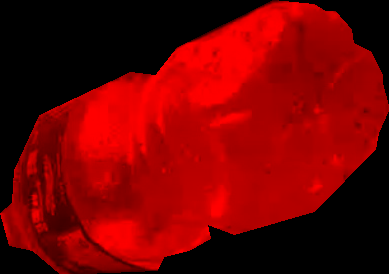

In [156]:
import plotly.express as plte

masked = res.orig_image.copy()
masked[res.mask == 0] = 0
plte.imshow(masked)